# Simulate a basic OOK transmission system

In [1]:
import numpy as np
from commpy.utilities  import upsample
from optic.models import mzm, photodiode
from optic.metrics import signal_power
from optic.dsp import firFilter, pulseShape, lowPassFIR
from optic.core import parameters
from optic.plot import eyediagram
import matplotlib.pyplot as plt
from scipy.special import erfc

Average power of the modulated optical signal [mW]: 0.01 mW
Average power of the modulated optical signal [dBm]: -23.00 dBm


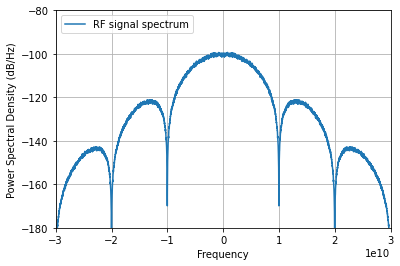

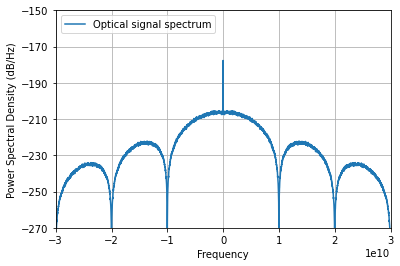

In [2]:
# simulation parameters
SpS = 16

Rs = 10e9 # Symbol rate (for OOK case Rs = Rb)
Tsymb = 1/Rs # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs # Sampling period

Pi_dBm = -20 # optical signal power at modulator input in dBm

# MZM parameters
Vπ = 2
Vb = -Vπ/2
Pi = 10**(Pi_dBm/10)*1e-3 # optical signal power in W at the MZM input

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=100000)
n = np.arange(0, bitsTx.size)

# map bits to electrical pulses
symbTx = 2*bitsTx-1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)

# optical modulation
Ai = np.sqrt(Pi)*np.ones(sigTx.size)
sigTxo = mzm(Ai, sigTx, Vπ, Vb)

print('Average power of the modulated optical signal [mW]: %.2f mW'%(signal_power(sigTxo)/1e-3))
print('Average power of the modulated optical signal [dBm]: %.2f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

# plot psd
plt.figure();
plt.xlim(-3*Rs,3*Rs);
plt.ylim(-180,-80);
plt.psd(sigTx,Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'RF signal spectrum')
plt.legend(loc='upper left');

# plot psd
plt.figure();
plt.xlim(-3*Rs,3*Rs);
plt.ylim(-270,-150);
plt.psd(np.abs(sigTxo)**2,Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'Optical signal spectrum')
plt.legend(loc='upper left');

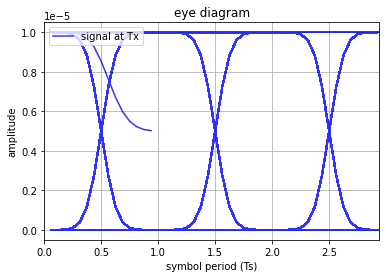

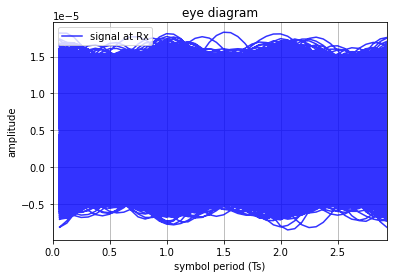

In [3]:
paramPD = parameters()
paramPD.ideal = True
I_Rx_ideal = photodiode(sigTxo.real, paramPD)

paramPD = parameters()
paramPD.ideal = False
paramPD.B = 10e9
paramPD.Fs = Fs

I_Rx = photodiode(sigTxo.real, paramPD)

eyediagram(I_Rx_ideal.copy(), I_Rx.size, SpS, plotlabel='signal at Tx')
eyediagram(I_Rx.copy(), I_Rx.size, SpS, plotlabel='signal at Rx')

I0 = -0.13 
I1 = 2.14 
σ0 = 0.37 
σ1 = 0.37 
Optimal decision threshold Id = 1.00 
Q = 3.08 

Number of counted errors = 91 
BER = 9.12e-04 
Pb = 1.04e-03 


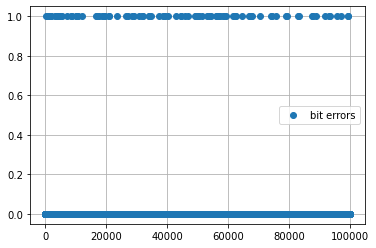

In [4]:
I_Rx = I_Rx/np.std(I_Rx)

# capture samples in the middle of signaling intervals
I_Rx = I_Rx[0::SpS]

# get received signal statistics

I1 = np.mean(I_Rx[bitsTx==1]) # average value of I1
I0 = np.mean(I_Rx[bitsTx==0]) # average value of I0

σ1 = np.std(I_Rx[bitsTx==1]) # standard deviation σ1 of I1
σ0 = np.std(I_Rx[bitsTx==0]) # standard deviation σ0 of I0

Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # optimal decision threshold
Q = (I1-I0)/(σ1 + σ0) # factor Q

print('I0 = %.2f '%(I0))
print('I1 = %.2f '%(I1))
print('σ0 = %.2f '%(σ0))
print('σ1 = %.2f '%(σ1))
print('Optimal decision threshold Id = %.2f '%(Id))
print('Q = %.2f \n'%(Q))

# Apply the optimal decision rule
bitsRx = np.empty(bitsTx.size)
bitsRx[I_Rx> Id] = 1
bitsRx[I_Rx<= Id] = 0

discard = 100
err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
print('Number of counted errors = %d '%(err.sum()))
print('BER = %.2e '%(BER))
print('Pb = %.2e '%(Pb))

plt.plot(err,'o', label = 'bit errors')
plt.legend()
plt.grid()

### Generate curve of BER vs receiver input power

In [9]:
# simulation parameters
SpS = 16
Rs = 40e9 # Symbol rate (for the OOK case, Rs = Rb)
Tsymb = 1/Rs # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs # Sampling period

# MZM parameters
Vπ = 2
Vb = -Vπ/2

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

powerValues = np.arange(-30,-9)
BER = np.zeros(powerValues.shape)
Pb = np.zeros(powerValues.shape)

for indPi, Pi_dBm in enumerate(powerValues):
    
    Pi = 10**((Pi_dBm+3)/10)*1e-3 # optical signal power in W at the MZM input
    
    # generate pseudo-random bit sequence
    bitsTx = np.random.randint(2, size=100000)
    n = np.arange(0, bitsTx.size)

    # map bits to electrical pulses
    symbTx = 2*bitsTx-1
    symbTx = symbTx/np.sqrt(signal_power(symbTx))

    # upsampling
    symbolsUp = upsample(symbTx, SpS)

    # pulse formatting
    sigTx = firFilter(pulse, symbolsUp)

    # optical modulation
    Ai = np.sqrt(Pi)*np.ones(sigTx.size)
    sigTxo = mzm(Ai, sigTx, Vπ, Vb)
    
    # pin receiver
    paramPD = parameters()
    paramPD.ideal = False
    paramPD.B = 1.1*Rs
    paramPD.Fs = Fs

    I_Rx = photodiode(sigTxo.real, paramPD)    
    I_Rx = I_Rx/np.std(I_Rx)

    # capture samples in the middle of signaling intervals
    I_Rx = I_Rx[0::SpS]

    # get received signal statistics

    I1 = np.mean(I_Rx[bitsTx==1]) # average value of I1
    I0 = np.mean(I_Rx[bitsTx==0]) # average value of I0

    σ1 = np.std(I_Rx[bitsTx==1]) # standard deviation σ1 of I1
    σ0 = np.std(I_Rx[bitsTx==0]) # standard deviation σ0 of I0

    Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # optimal decision threshold
    Q = (I1-I0)/(σ1 + σ0) # Q-factor

    # Aplica a regra de decisão ótima
    bitsRx = np.empty(bitsTx.size)
    bitsRx[I_Rx>  Id] = 1
    bitsRx[I_Rx<= Id] = 0

    discard = 100
    err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
    BER[indPi] = np.mean(err)
    Pb[indPi] = 0.5*erfc(Q/np.sqrt(2)) # probability of bit error (theory)

C:\Users\edson\AppData\Local\Temp\ipykernel_20048\3165622829.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(powerValues, np.log10(BER),'o',label='BER')


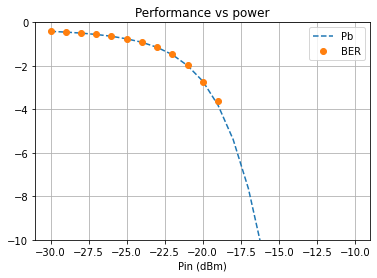

In [10]:
plt.figure()
plt.plot(powerValues, np.log10(Pb),'--',label='Pb')
plt.plot(powerValues, np.log10(BER),'o',label='BER')
plt.grid()
plt.xlabel('Pin (dBm)');
plt.title('Performance vs power')
plt.legend();
plt.ylim(-10,0);